# Variational Inference: Bayesian Neural Networks

author: Thomas Wiecki, updated by Chris Fonnesbeck from original article: https://www.pymc.io/projects/examples/en/latest/variational_inference/bayesian_neural_network_advi.html

Modified for Class demonstration by Mark Fuge


## Bayesian Neural Networks in PyMC

### Generating data

First, lets generate some toy data -- a simple binary classification problem that's not linearly separable.

In [ ]:
import aesara
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import seaborn as sns

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

In [ ]:
%config InlineBackend.figure_format = 'retina'
floatX = aesara.config.floatX
RANDOM_SEED = 9927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [ ]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

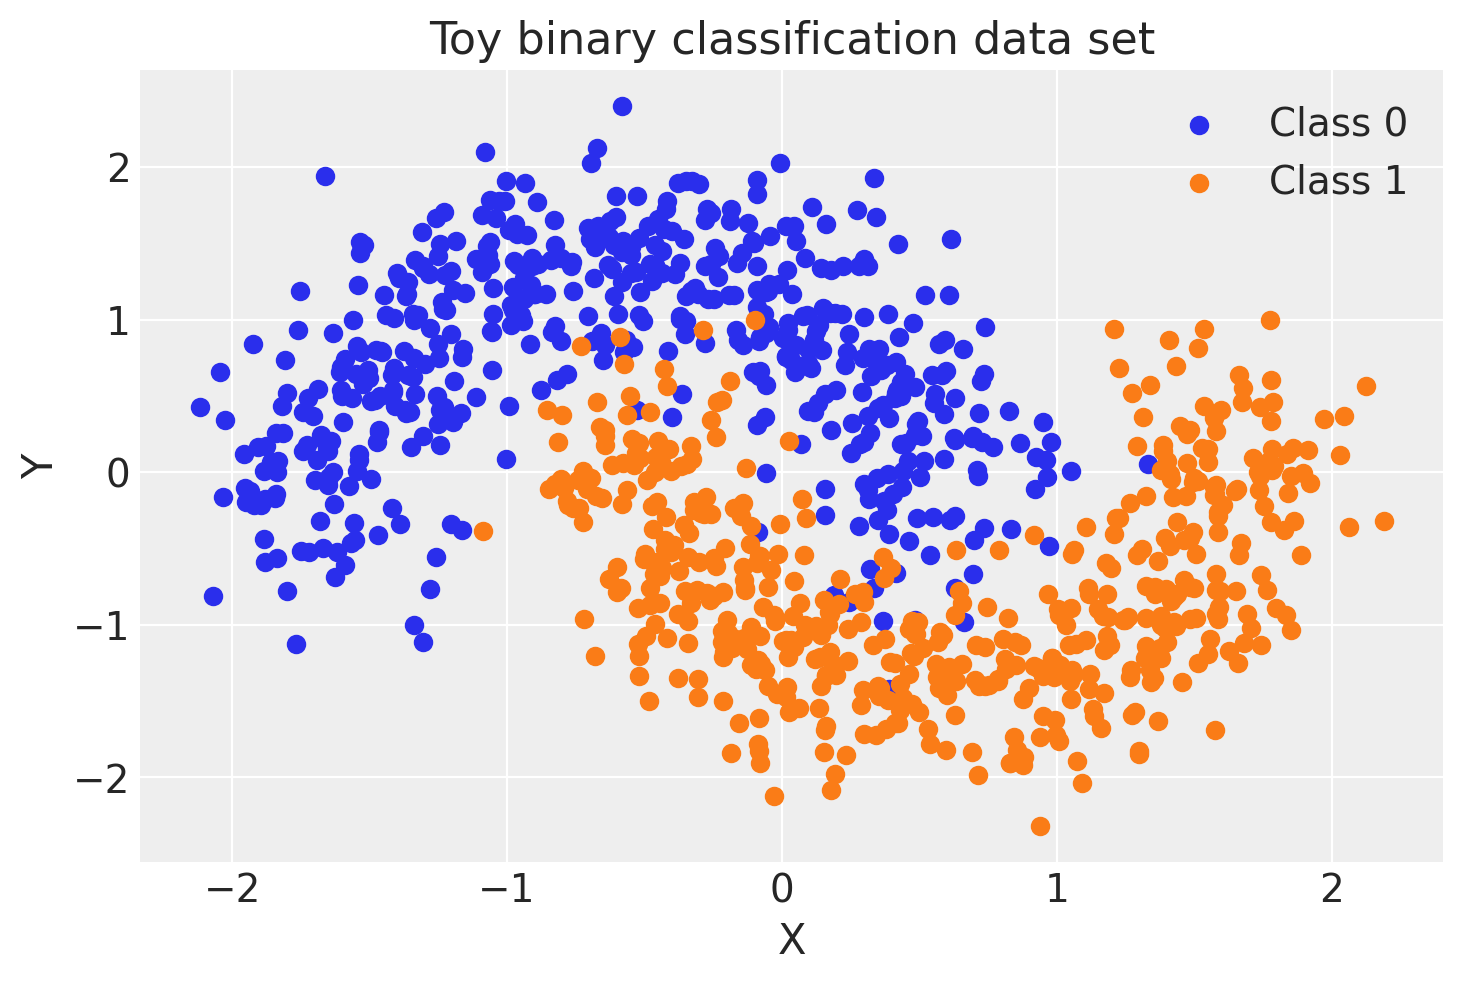

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X[Y == 0, 0], X[Y == 0, 1], color="C0", label="Class 0")
ax.scatter(X[Y == 1, 0], X[Y == 1, 1], color="C1", label="Class 1")
sns.despine()
ax.legend()
ax.set(xlabel="X", ylabel="Y", title="Toy binary classification data set");

### Model specification

A neural network is quite simple. The basic unit is a [perceptron](https://en.wikipedia.org/wiki/Perceptron) which is nothing more than [logistic regression](http://pymc-devs.github.io/pymc3/notebooks/posterior_predictive.html#Prediction). We use many of these in parallel and then stack them up to get hidden layers. Here we will use 2 hidden layers with 5 neurons each which is sufficient for such a simple problem.

In [ ]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5

    # Initialize random weights between each layer
    init_1 = rng.standard_normal(size=(X_train.shape[1], n_hidden)).astype(floatX)
    init_2 = rng.standard_normal(size=(n_hidden, n_hidden)).astype(floatX)
    init_out = rng.standard_normal(size=n_hidden).astype(floatX)

    coords = {
        "hidden_layer_1": np.arange(n_hidden),
        "hidden_layer_2": np.arange(n_hidden),
        "train_cols": np.arange(X_train.shape[1]),
        # "obs_id": np.arange(X_train.shape[0]),
    }
    with pm.Model(coords=coords) as neural_network:
        ann_input = pm.Data("ann_input", X_train, mutable=True)
        ann_output = pm.Data("ann_output", Y_train, mutable=True)

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal(
            "w_in_1", 0, sigma=1, initval=init_1, dims=("train_cols", "hidden_layer_1")
        )

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal(
            "w_1_2", 0, sigma=1, initval=init_2, dims=("hidden_layer_1", "hidden_layer_2")
        )

        # Weights from hidden layer to output
        weights_2_out = pm.Normal("w_2_out", 0, sigma=1, initval=init_out, dims="hidden_layer_2")

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli(
            "out",
            act_out,
            observed=ann_output,
            total_size=Y_train.shape[0],  # IMPORTANT for minibatches
        )
    return neural_network


neural_network = construct_nn(X_train, Y_train)

That's not so bad. The `Normal` priors help regularize the weights. Usually we would add a constant `b` to the inputs but I omitted it here to keep the code cleaner.

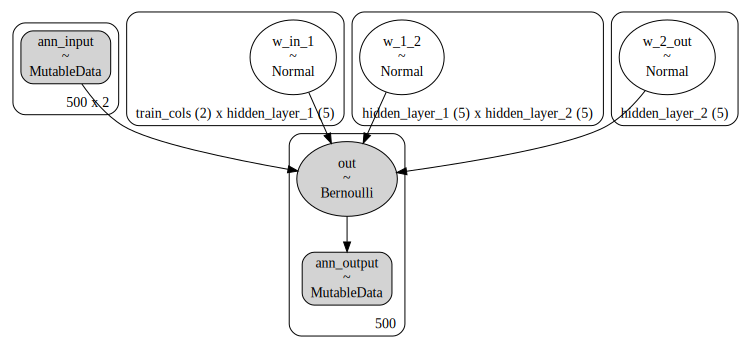

In [ ]:
# Plot the graphical model
pm.model_to_graphviz(neural_network)

### Option 1: MCMC Inference
Sampling using something like NUTS will be pretty slow as we increase the number of dimensions and complexity of the network


In [ ]:
%%time
# Careful -- will take a long time
with neural_network:
    trace = pm.sample(2000,tune=100,cores=-1)

ERROR:pymc:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


CPU times: user 15min 13s, sys: 7.47 s, total: 15min 21s
Wall time: 15min 19s


### Option 2: Variational Inference: Scaling model complexity

We could now just run a MCMC sampler like `pymc.NUTS` which works pretty well in this case, but was already mentioned, this will become very slow as we scale our model up to deeper architectures with more layers.

Instead, we will use the `pymc.ADVI` variational inference algorithm. This is much faster and will scale better. Note, that this is a mean-field approximation so we ignore correlations in the posterior.

In [ ]:
%%time

with neural_network:
    approx = pm.fit(n=30_000)

CPU times: user 48.8 s, sys: 1.98 s, total: 50.8 s
Wall time: 1min 51s


Plotting the objective function (ELBO) we can see that the optimization iteratively improves the fit.

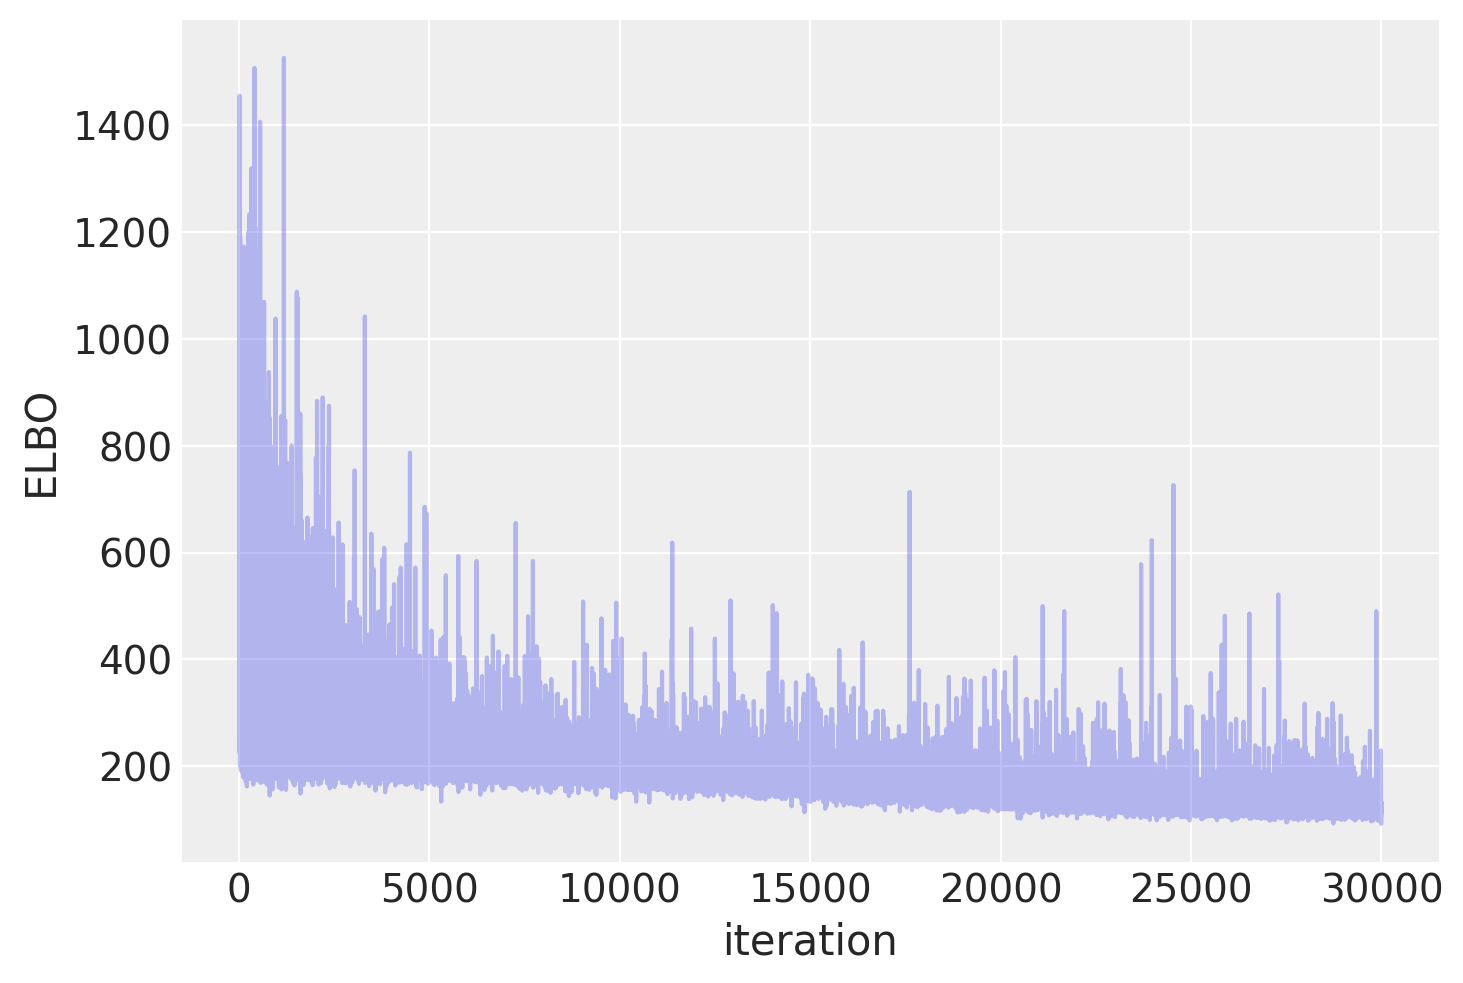

In [ ]:
plt.plot(approx.hist, alpha=0.3)
plt.ylabel("ELBO")
plt.xlabel("iteration");

In [ ]:
trace = approx.sample(draws=5000)

Now that we trained our model, lets predict on the hold-out set using a posterior predictive check (PPC). We can use `~pymc.sample_posterior_predictive` to generate new data (in this case class predictions) from the posterior (sampled from the variational estimation).

In [ ]:
with neural_network:
    pm.set_data(new_data={"ann_input": X_test})
    ppc = pm.sample_posterior_predictive(trace)
    trace.extend(ppc)

We can average the predictions for each observation to estimate the underlying probability of class 1.

In [ ]:
pred = ppc.posterior_predictive["out"].mean(("chain", "draw")) > 0.5

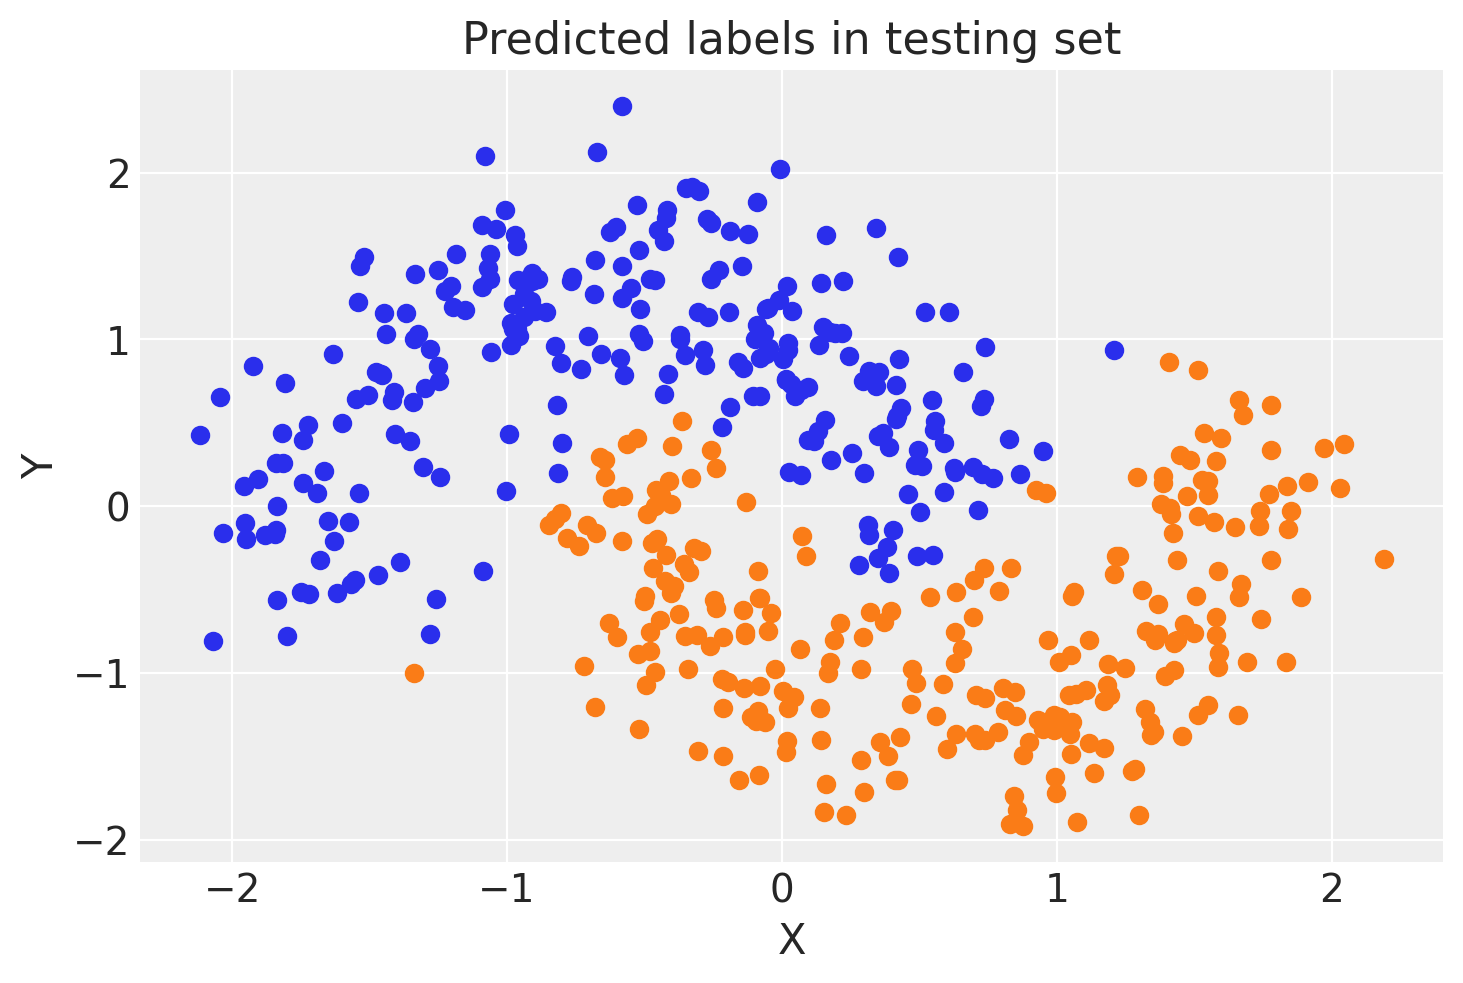

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1], color="C0")
ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="C1")
sns.despine()
ax.set(title="Predicted labels in testing set", xlabel="X", ylabel="Y");

In [ ]:
print(f"Accuracy = {(Y_test == pred.values).mean() * 100}%")

Accuracy = 94.6%


Hey, our neural network did all right!

## Lets look at what the classifier has learned

For this, we evaluate the class probability predictions on a grid over the whole input space.

In [ ]:
grid = pm.floatX(np.mgrid[-3:3:100j, -3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [ ]:
with neural_network:
    pm.set_data(new_data={"ann_input": grid_2d, "ann_output": dummy_out})
    ppc = pm.sample_posterior_predictive(trace)

In [ ]:
y_pred = ppc.posterior_predictive["out"]

### Probability surface

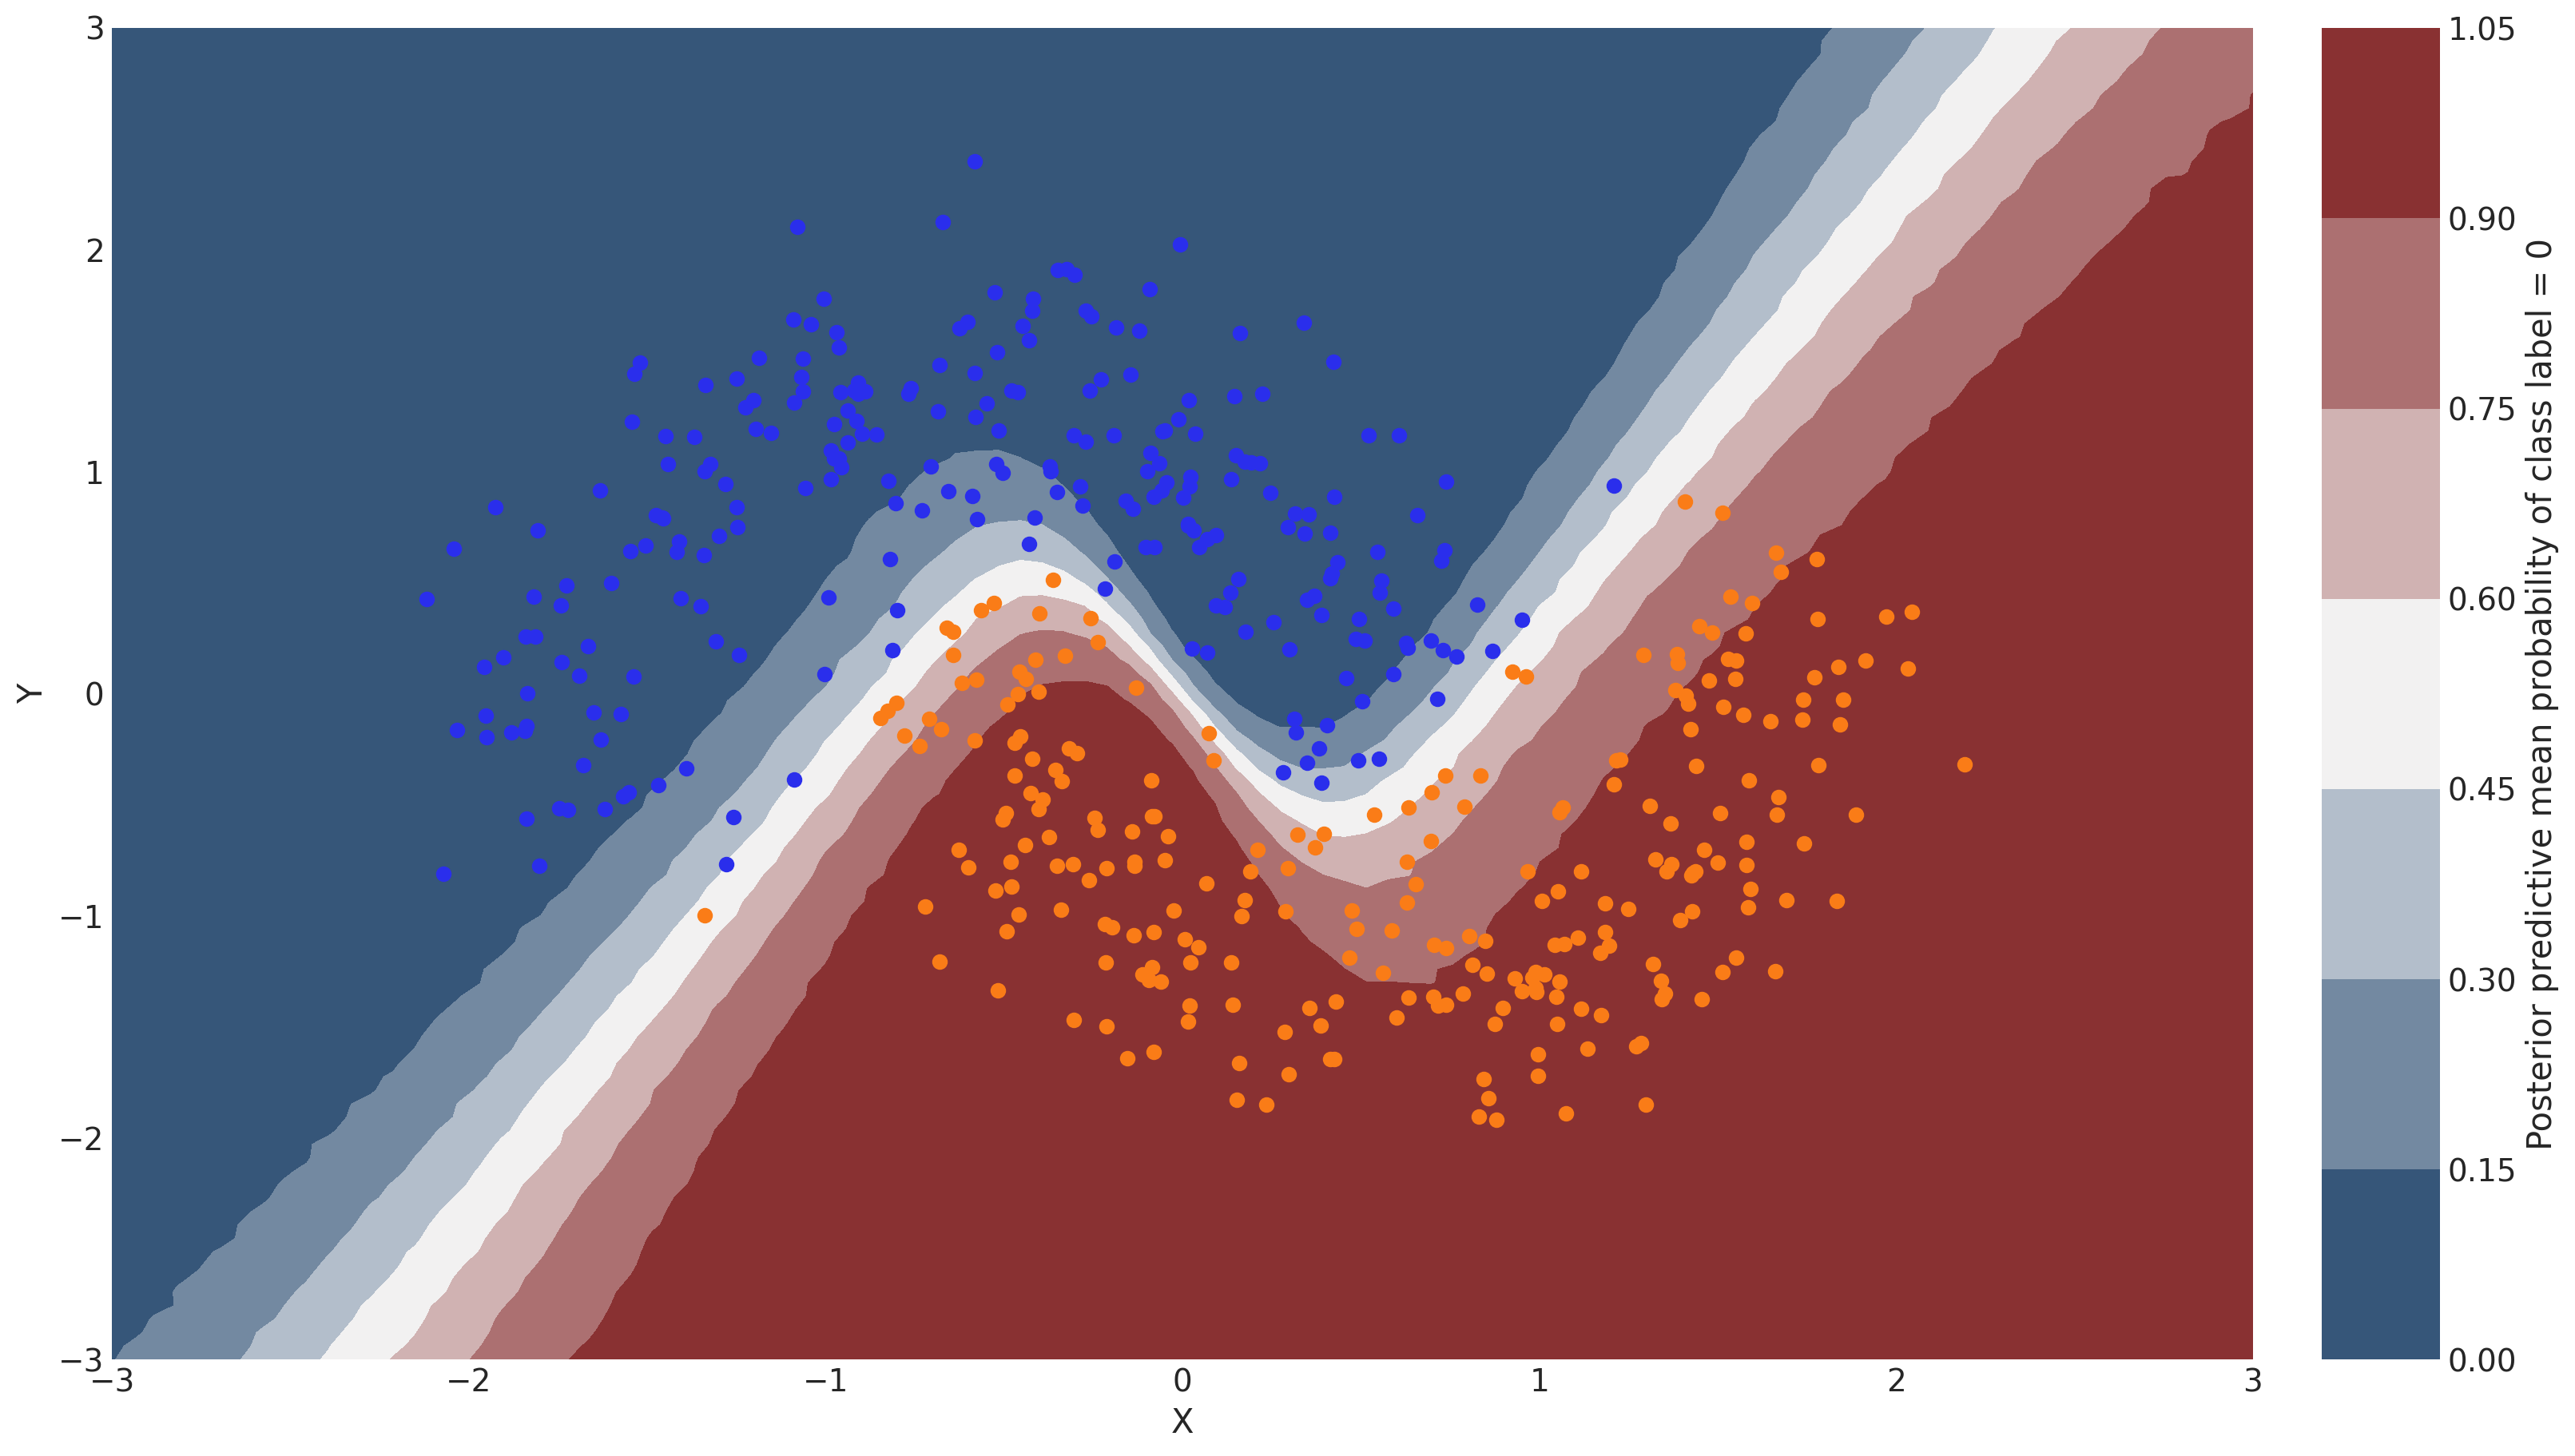

In [ ]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(
    grid[0], grid[1], y_pred.mean(("chain", "draw")).values.reshape(100, 100), cmap=cmap
)
ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1], color="C0")
ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="C1")
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel="X", ylabel="Y")
cbar.ax.set_ylabel("Posterior predictive mean probability of class label = 0");

### Viewing the Uncertainty in the NN weights

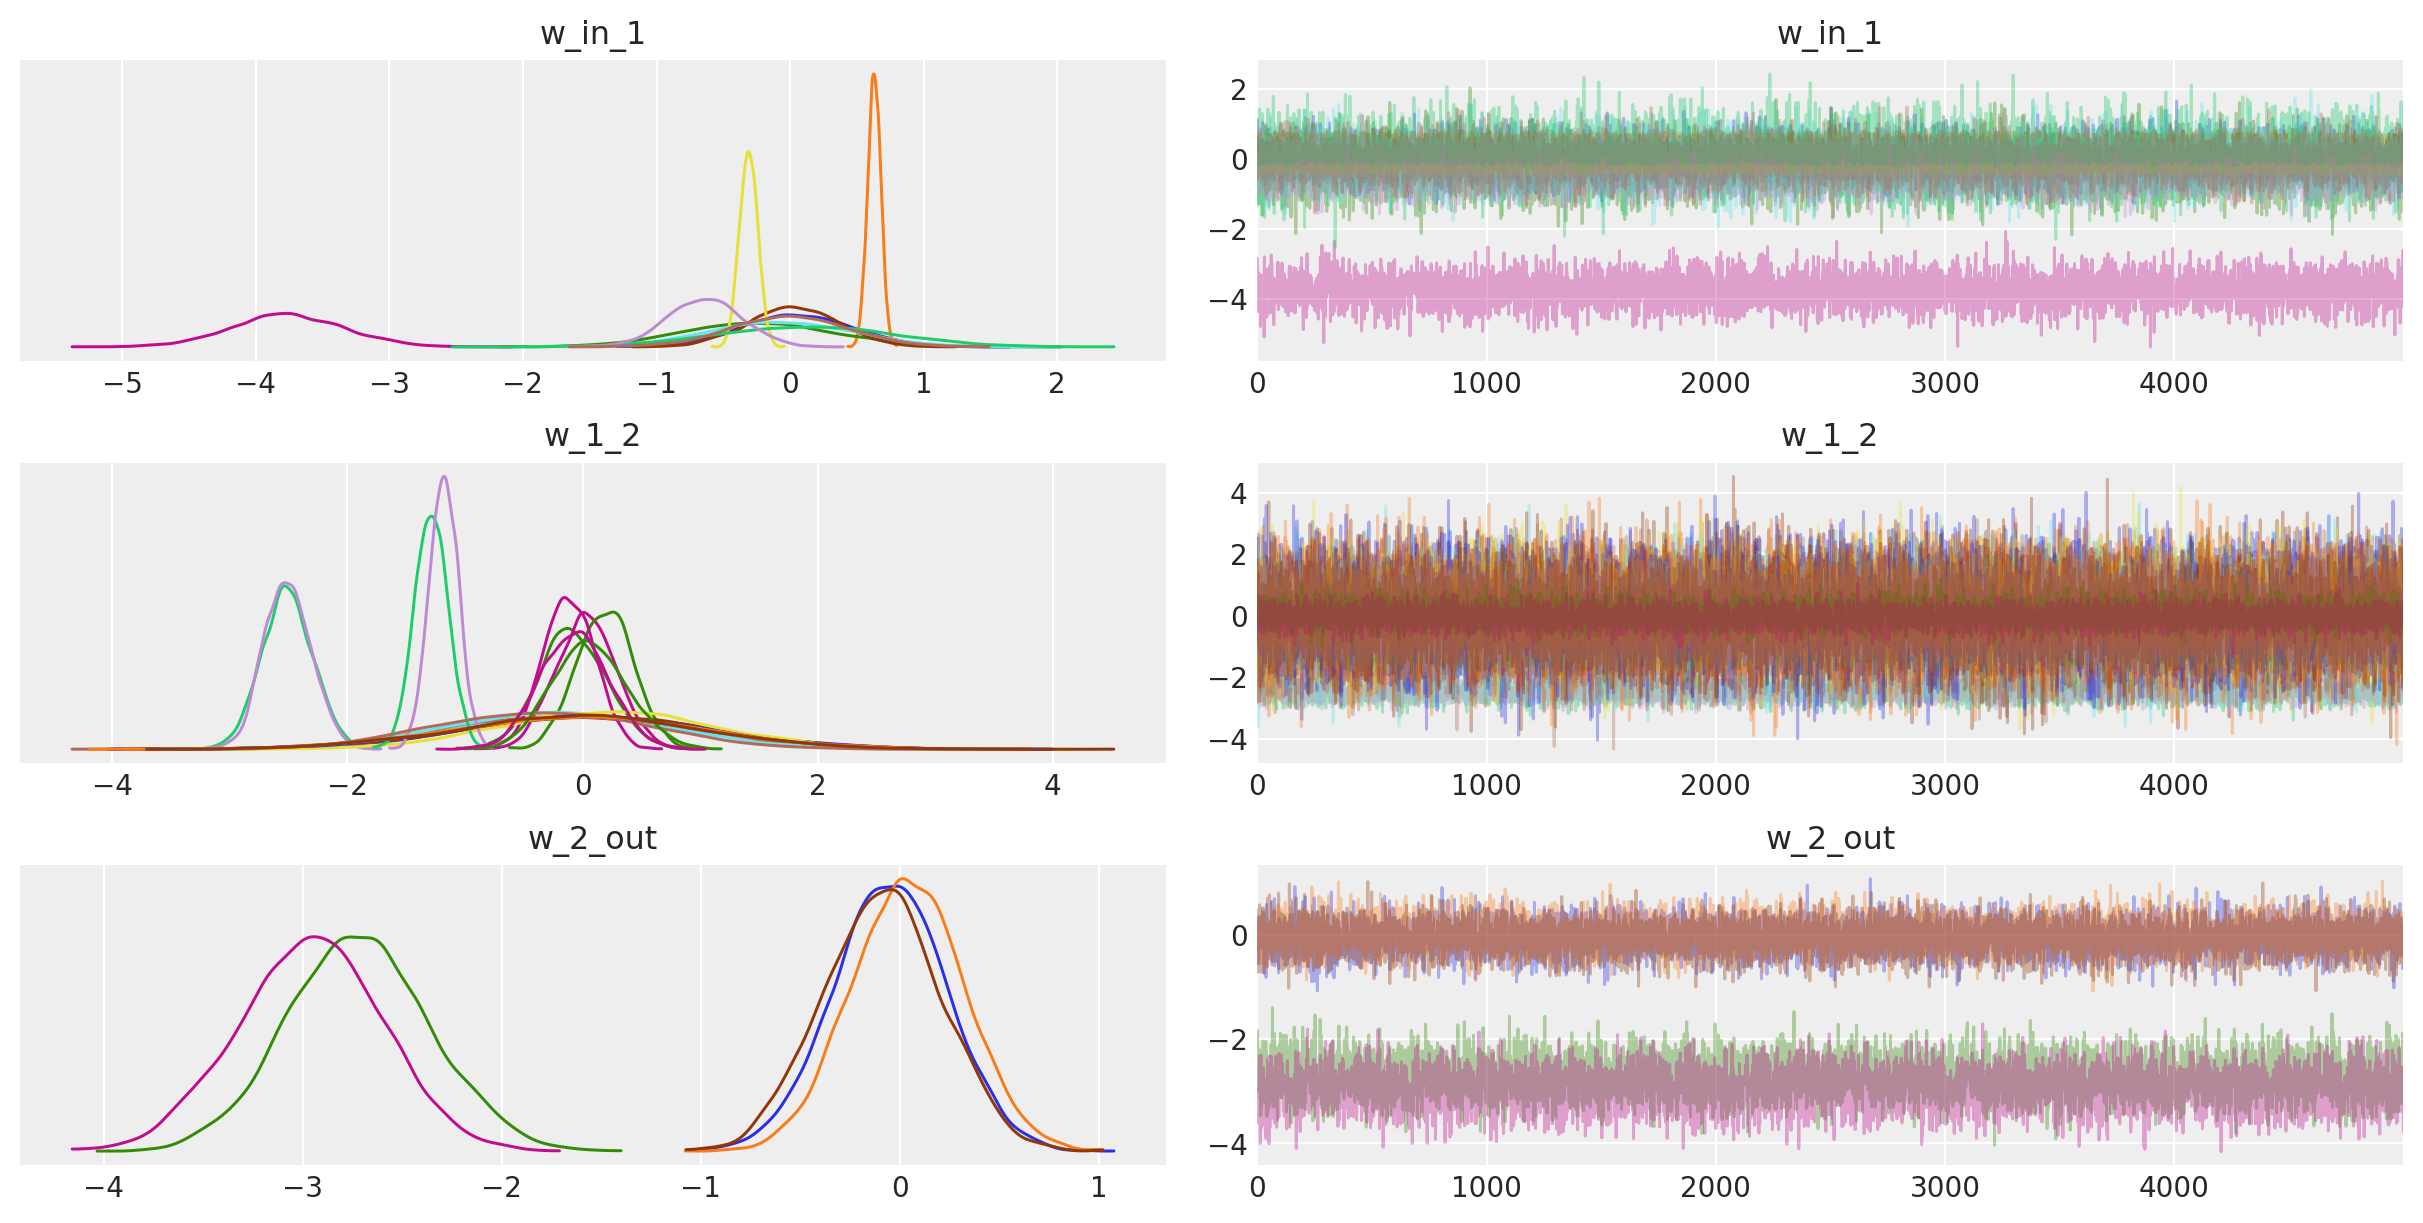

In [ ]:
az.plot_trace(trace);

### Uncertainty in predicted value

Note that we could have done everything above with a non-Bayesian Neural Network. The mean of the posterior predictive for each class-label should be identical to maximum likelihood predicted values. However, we can also look at the standard deviation of the posterior predictive to get a sense for the uncertainty in our predictions. Here is what that looks like:

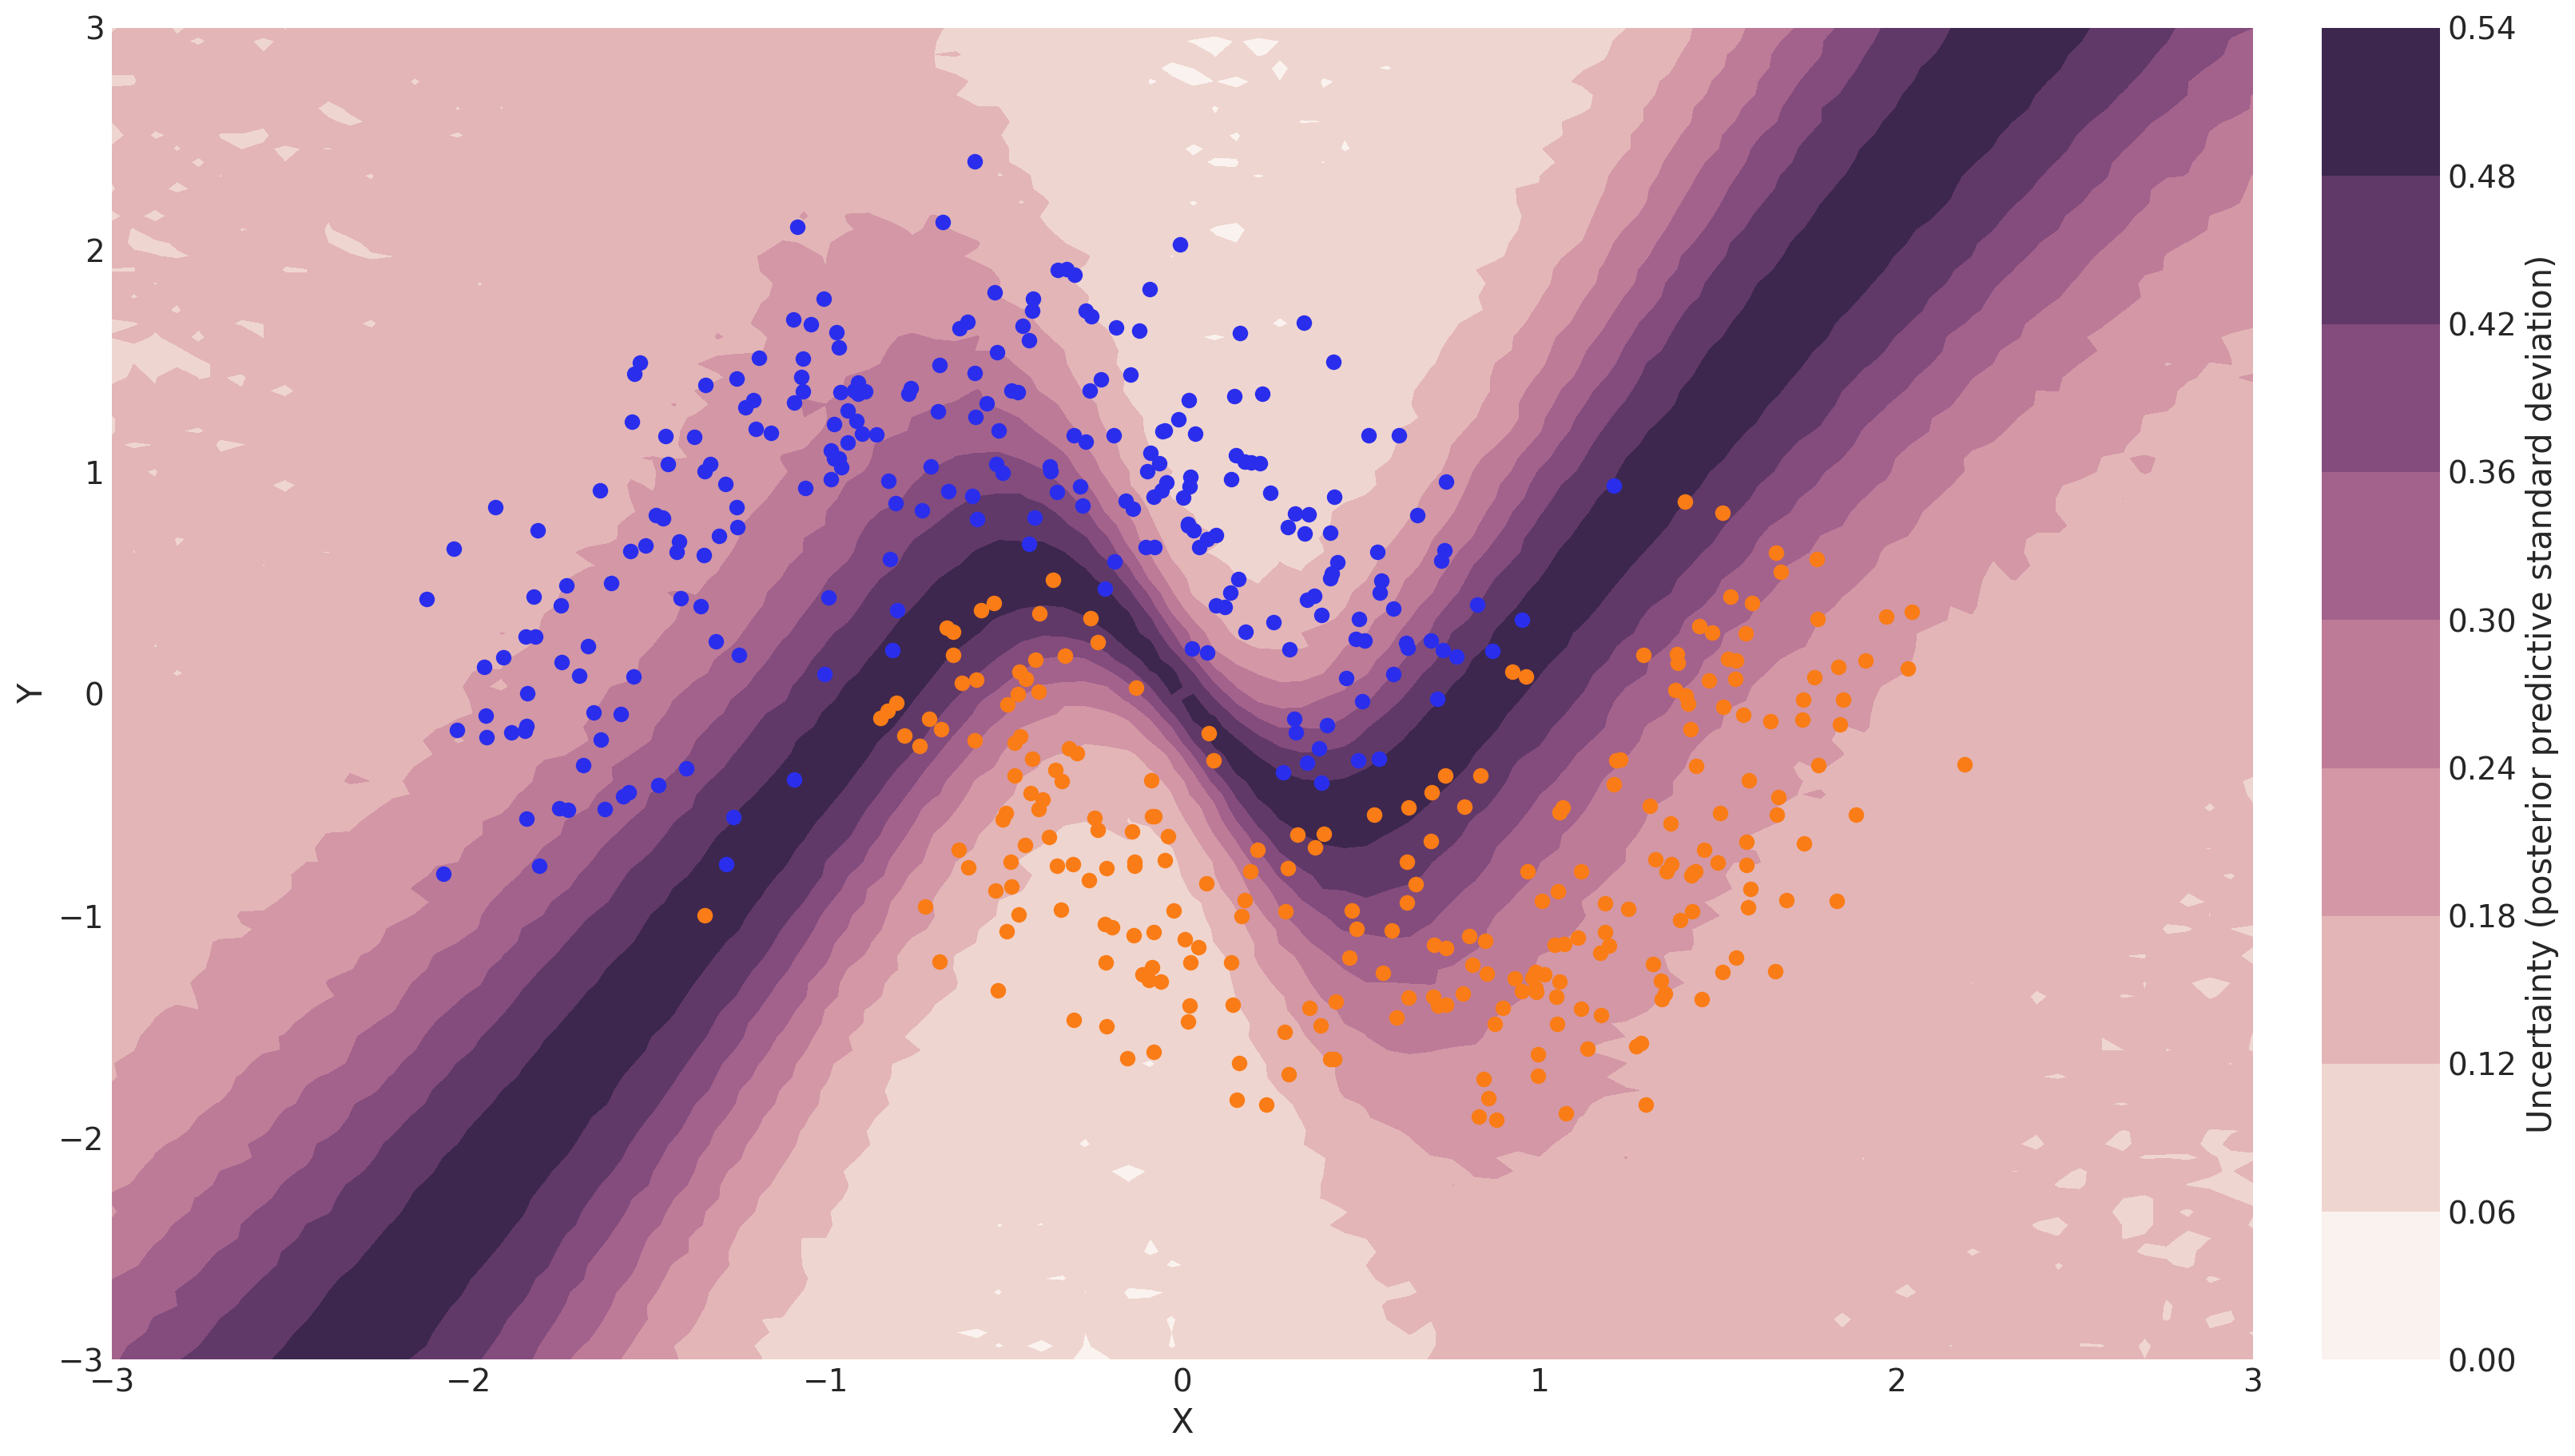

In [ ]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(
    grid[0], grid[1], y_pred.squeeze().values.std(axis=0).reshape(100, 100), cmap=cmap
)
ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1], color="C0")
ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="C1")
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel="X", ylabel="Y")
cbar.ax.set_ylabel("Uncertainty (posterior predictive standard deviation)");

We can see that very close to the decision boundary, our uncertainty as to which label to predict is highest. You can imagine that associating predictions with uncertainty is a critical property for many applications like health care. To further maximize accuracy, we might want to train the model primarily on samples from that high-uncertainty region.

## Mini-batch ADVI

So far, we have trained our model on all data at once. Obviously this won't scale to something like ImageNet. Moreover, training on mini-batches of data (stochastic gradient descent) avoids local minima and can lead to faster convergence.

Fortunately, ADVI can be run on mini-batches as well. It just requires some setting up:

In [ ]:
%%time
minibatch_x = pm.Minibatch(X_train, batch_size=50)
minibatch_y = pm.Minibatch(Y_train, batch_size=50)
neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)
with neural_network_minibatch:
    approx = pm.fit(40000, method=pm.ADVI())

CPU times: user 1min 2s, sys: 876 ms, total: 1min 3s
Wall time: 1min 7s


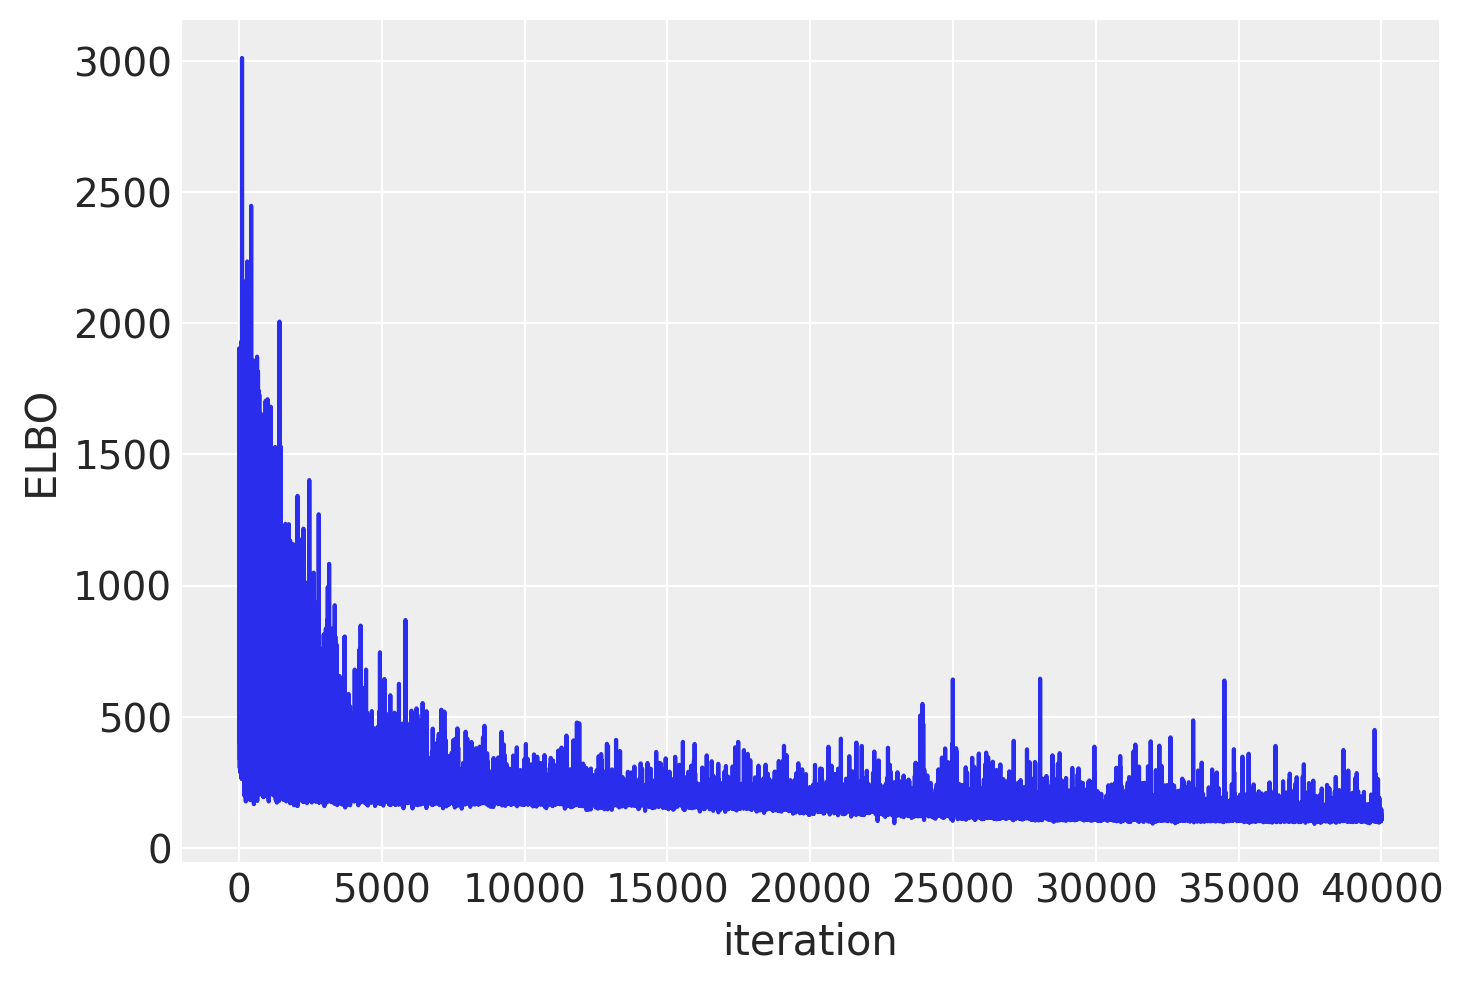

In [ ]:
plt.plot(approx.hist)
plt.ylabel("ELBO")
plt.xlabel("iteration");

As you can see, mini-batch ADVI's running time is much lower. It also seems to converge faster.

For fun, we can also look at the trace. The point is that we also get uncertainty of our Neural Network weights.

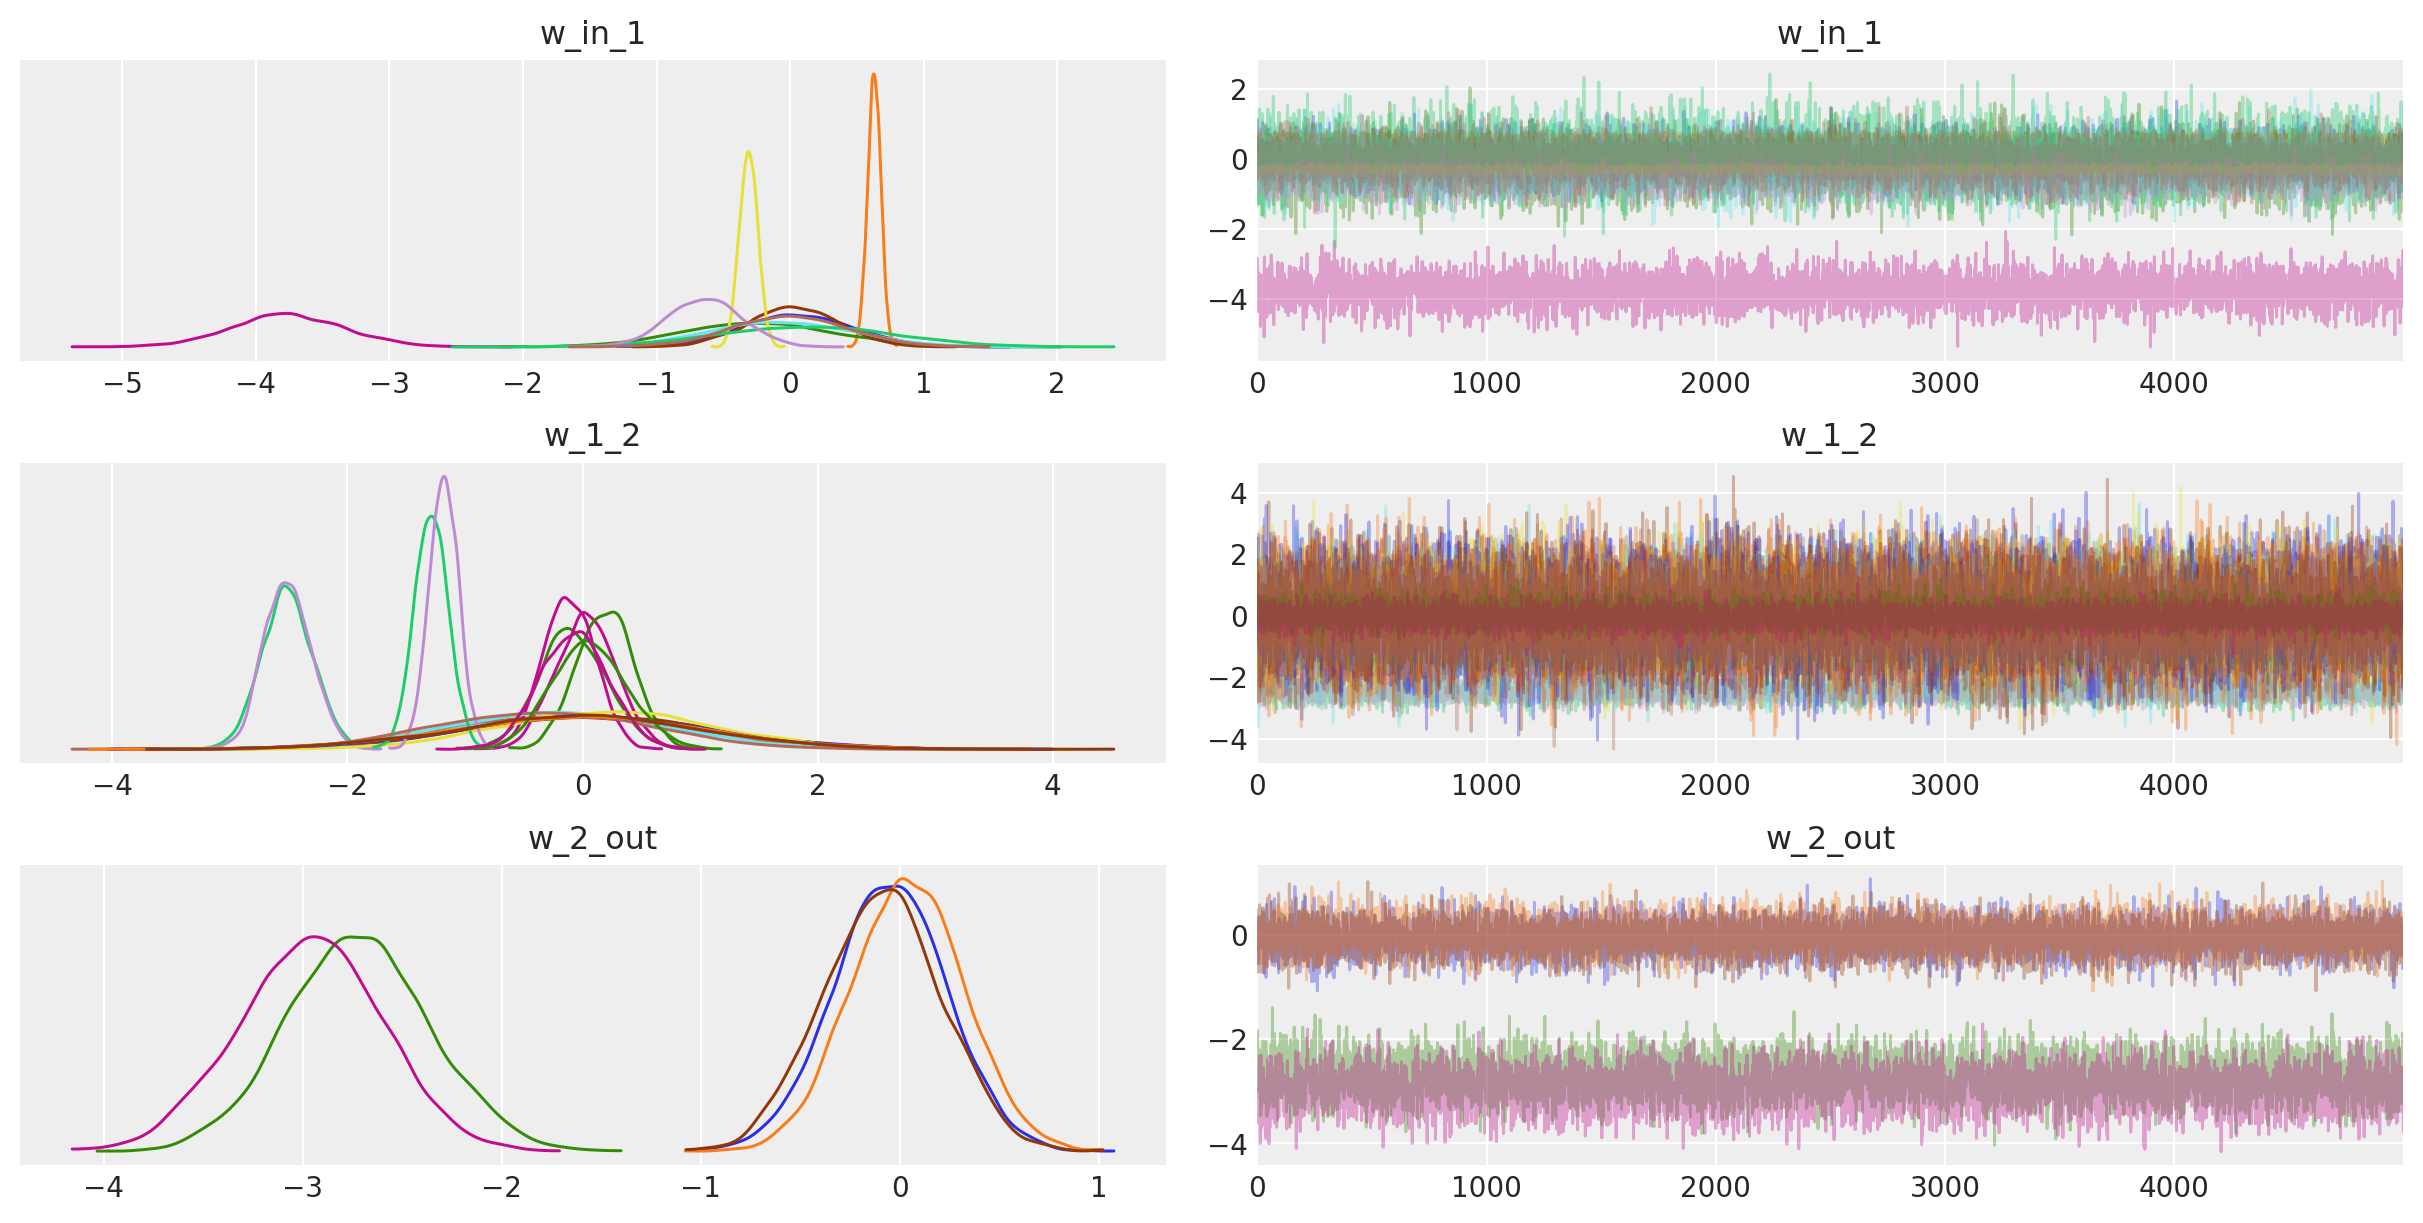

In [ ]:
az.plot_trace(trace);

You might argue that the above network isn't really deep, but note that we could easily extend it to have more layers, including convolutional ones to train on more challenging data sets.

## Acknowledgements

[Taku Yoshioka](https://github.com/taku-y) did a lot of work on ADVI in PyMC3, including the mini-batch implementation as well as the sampling from the variational posterior. I'd also like to the thank the Stan guys (specifically Alp Kucukelbir and Daniel Lee) for deriving ADVI and teaching us about it. Thanks also to Chris Fonnesbeck, Andrew Campbell, Taku Yoshioka, and Peadar Coyle for useful comments on an earlier draft.

## Authors

- This notebook was originally authored as a [blog post](https://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/) by Thomas Wiecki in 2016
- Updated by Chris Fonnesbeck for PyMC v4 in 2022

## Watermark

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

Last updated: Fri May 06 2022

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.1.1

xarray: 2022.3.0

arviz     : 0.12.0
aesara    : 2.6.2
matplotlib: 3.5.1
sys       : 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:24:11) 
[GCC 9.4.0]
numpy     : 1.22.2
seaborn   : 0.11.2
pymc      : 4.0.0b6

Watermark: 2.3.0

